In [515]:
import numpy as np
import pandas as pd
import json
import sqlite3

import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim 
import folium

from datetime import datetime, timedelta
import pytz

## Scrapped data inspection
03172021
### see how many places don't have `popular times` field - especially for PA state parks and forests (which were added later)

In [118]:
# results contain named tuple: 
#     PopularTimes(place_id, rating, rating_n, popular_times, current_popularity, time_spent)
conn = sqlite3.connect("data/philly_outdoor_popularity_half_hour_0316_0317.db")
raw_resp = pd.read_sql_query("SELECT results FROM curr_popularity LIMIT 1784", conn)

resp_popular_times = [json.loads(i)[3] for i in raw_resp['results']]

66


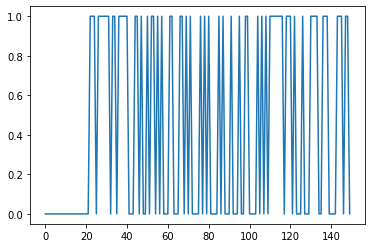

In [119]:
print(np.sum([0 if i else 1 for i in resp_popular_times[-150:]])) # oops, 70 of them had no `popular times`
plt.plot([0 if i else 1 for i in resp_popular_times[-150:]]); # well, so most of state parks/forests don't have `popular times`
# if it has it will report data for 7 days (even when not open)

In [120]:
days_with_poptime_per_week = [len(i) for i in resp_popular_times if i]
np.unique(days_with_poptime_per_week)

array([7])

### Time series for the ones with curr_popularity

In [121]:
pop_df = pd.read_sql_query("SELECT id, request_id, rating_n, timestamp, curr_popularity FROM curr_popularity", conn)
conn.close()

In [122]:
# find the ones with 'curr_popularity'
place_with_currpop = pop_df[pop_df['curr_popularity']>=0]['id'].unique()
print('# of parks with curr_popularity ' + str(place_with_currpop.shape[0]))

# of parks with curr_popularity 223


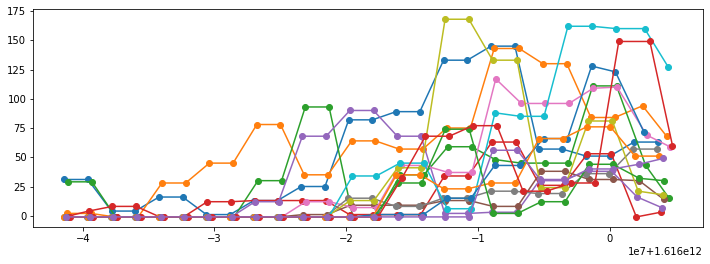

In [123]:
# for each of these parks, draw curr_popularity changes as a func of timestamp (sampled a few places)
plt.figure(figsize=[12, 4])
for iexample in range(0, place_with_currpop.shape[0], 15):
    # select entry with the given id
    sub_pop_df = pop_df[pop_df['id'] == place_with_currpop[iexample]]
    plt.plot(sub_pop_df['timestamp'].tolist(), sub_pop_df['curr_popularity'].tolist(), '-o')
    

### What about a subset of parks that are state system parks/forests

In [129]:
# load state parks
conn = sqlite3.connect('philly_state_parks_info.db')
philly_state_parks = pd.read_sql_query("SELECT id, name, lat, lng FROM info", conn)
conn.close()
philly_state_parks = philly_state_parks.set_index('id')

In [130]:
state_with_currpop = list(set(place_with_currpop) & set(philly_state_parks.index))
len(state_with_currpop)

24

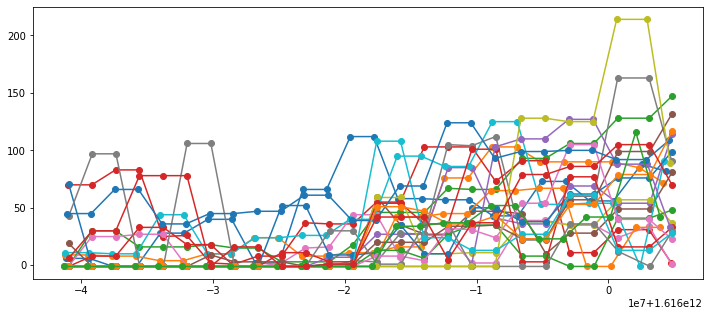

In [134]:
# for state system parks
plt.figure(figsize=[12, 5])
for iexample in state_with_currpop:
    # select entry with the given id
    sub_pop_df = pop_df[pop_df['id'] == iexample]
    plt.plot(sub_pop_df['timestamp'].tolist(), sub_pop_df['curr_popularity'].tolist(), '-o')
 

## Visualize the ones with high live popularity numbers
Need geometry for this, query `info` tables. 

In [132]:
geolocator = Nominatim(user_agent="pa_explorer")

address = 'Centre County, PA'
location = geolocator.geocode(address)
latitude_pa = location.latitude
longitude_pa = location.longitude

# create map using latitude and longitude values

map_pa = folium.Map(location=[latitude_pa, longitude_pa], zoom_start=7.5)

# add markers to map
for item in state_with_currpop:
    label = "{}".format(philly_state_parks.loc[item,'name'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [philly_state_parks.loc[item,'lat'], philly_state_parks.loc[item,'lng']], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, 
        parse_html=False).add_to(map_pa)  

map_pa

## Load `curr_popularity` data

In [459]:
# curr_popularity
def load_curr_popularity(database_name):
    conn = sqlite3.connect(database_name)
    data = pd.read_sql_query("SELECT id, request_id, rating_n, timestamp, curr_popularity FROM curr_popularity WHERE curr_popularity>=0", conn)
    conn.close()
    return data

In [460]:
philly_0331 = load_curr_popularity("data/philly_outdoor_popularity_half_hour_0331_0401.db")
nyc_0331 = load_curr_popularity("data/nyc_outdoor_popularity_half_hour_0331_0401.db")

### Philly
merge existing sections

In [396]:
# load data from various days
philly_df = pd.concat((philly_0316, philly_0317, philly_0318, philly_0319, philly_0320, philly_0321, philly_0322, 
                       philly_0324, philly_0327, philly_0328, philly_0329, philly_0331), axis=0)
philly_df.columns

Index(['id', 'request_id', 'rating_n', 'timestamp', 'curr_popularity'], dtype='object')

In [451]:
# preprocessing of time
philly_df['datetime'] = philly_df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
philly_df['date'] = philly_df['datetime'].apply(lambda x: x.date)
philly_df['hour'] = philly_df['datetime'].apply(lambda x: x.hour)

philly_df.head()

,id,request_id,rating_n,timestamp,curr_popularity,datetime,date,hour
0,ChIJzcow6Xb1t4kRQVE7s1AWWr8,ChIJzcow6Xb1t4kRQVE7s1AWWr8,4,1615958558900,-1,2021-03-17 01:22:38.900,<built-in method date of Timestamp object at 0...,1
1,ChIJ_bk5K1z1t4kRQNverIUOVko,ChIJ_bk5K1z1t4kRQNverIUOVko,175,1615958558999,-1,2021-03-17 01:22:38.999,<built-in method date of Timestamp object at 0...,1
2,ChIJAWkAqNL1t4kRlm4slspOSXo,ChIJAWkAqNL1t4kRlm4slspOSXo,1314,1615958559002,-1,2021-03-17 01:22:39.002,<built-in method date of Timestamp object at 0...,1
3,ChIJAWkAqNL1t4kRlm4slspOSXo,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,1314,1615958559003,-1,2021-03-17 01:22:39.003,<built-in method date of Timestamp object at 0...,1
4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,351,1615958560063,-1,2021-03-17 01:22:40.063,<built-in method date of Timestamp object at 0...,1


In [ ]:
# load philly park info
conn = sqlite3.connect('philly_parks_info.db')
philly_parks = pd.read_sql_query("SELECT id, name, lat, lng FROM info", conn)
conn.close()

philly_parks = philly_parks.set_index('id')

In [364]:
def visualize_curr_pop_dynamics(curr_df, info_df, sample_size=5):
    """
    Visualize the dynamics of current popularity scraped from Google. Display the park names if sample_size<=5.
    Input: curr_df - data with curr_popularity; 
           info_df - basic information about the parks, so their names can be found (indexed by place_id)
    
    """
    
    # find the unique place id with 'curr_popularity'
    place_with_currpop = curr_df[curr_df['curr_popularity']>=0]['id'].unique()
    print('# of parks with curr_popularity ' + str(place_with_currpop.shape[0]))
    
    # for sampled parks, draw curr_popularity dynamics
    plt.figure(figsize=[15, 4])
    # select examples to visualize
    sample_ind = np.random.choice(len(place_with_currpop), sample_size, replace=False)
    for iexample in sample_ind:
        if place_with_currpop[iexample] in info_df.index: # TODO, place_id and request_id conflict...
            # select entry with the given id
            sub_pop_df = curr_df[curr_df['id'] == place_with_currpop[iexample]]
            plt.plot(sub_pop_df['timestamp'].tolist(), sub_pop_df['curr_popularity'].tolist(), '-o', 
                     label=info_df.loc[place_with_currpop[iexample],'name'])
    if sample_size <= 10:
        plt.legend()
    
    return place_with_currpop

# of parks with curr_popularity 337


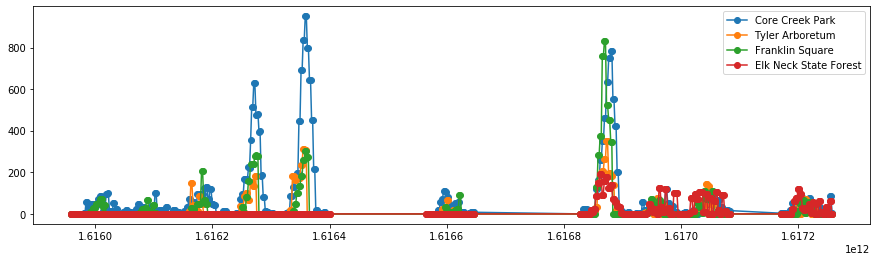

In [399]:
place_with_currpop_philly = visualize_curr_pop_dynamics(philly_df, philly_parks, sample_size=5);

In [368]:
def visualize_curr_pop_dynamics_by_placeid(place_id, curr_df, info_df):
    plt.figure(figsize=[15,4])
    if type(place_id) is not list:
        place_id = [place_id]
    for place_index in place_id: 
        sub_pop_df = curr_df[curr_df['id'] == place_index]
        plt.plot(sub_pop_df['timestamp'].tolist(), sub_pop_df['curr_popularity'].tolist(), '-o', 
                 label=info_df.loc[place_index,'name'])
    plt.legend()

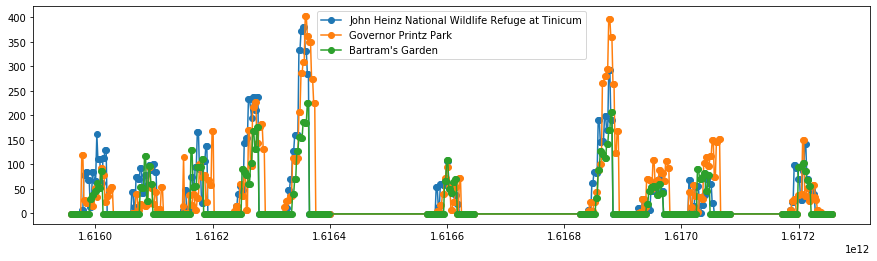

In [400]:
example_place_id = ['ChIJ2SMy_xLDxokR8mn3ZUlRNEI', 'ChIJR49aJNLCxokR2VlzjLsXVbI', 'ChIJmTX_74TGxokRtJ5tELv_3ms']
visualize_curr_pop_dynamics_by_placeid(example_place_id, philly_df, philly_parks)

In [405]:
# inspect foursquare_type for these parks
fsq_types = pd.read_parquet('philly_park_foursquare_types.parquet')

In [410]:
# fsq_types[fsq_types['id'] == 'ChIJ2SMy_xLDxokR8mn3ZUlRNEI']
fsq_types[fsq_types['id'] == 'ChIJR49aJNLCxokR2VlzjLsXVbI']
# fsq_types[fsq_types['id'] == 'ChIJmTX_74TGxokRtJ5tELv_3ms']

,id,name,lat,lng,fsq_name,fsq_type_name,fsq_type_id,fsq_type_name_simplified
870,ChIJR49aJNLCxokR2VlzjLsXVbI,Governor Printz Park,39.861449,-75.303195,Governor Printz Park,Park,4bf58dd8d48988d163941735,Park


In [332]:
# visualize their locations
info_df = philly_parks; place_id_to_display = place_with_currpop_philly; zoom_start=9; city = "Philadelphia, PA"
geolocator = Nominatim(user_agent="loc_explorer")
    
# center for visualization
address = city
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map using latitude and longitude values
map_pa = folium.Map(location=[latitude, longitude], zoom_start=zoom_start)

# add markers to map
for item in place_id_to_display:
    if item in info_df.index: # sometimse only request_id is in the info table, skip...
        label = "{}".format(info_df.loc[item,'name'])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [info_df.loc[item,'lat'], info_df.loc[item,'lng']], radius=5, popup=label, color='blue', 
            fill=True, fill_color='#3186cc', fill_opacity=0.7, 
            parse_html=False).add_to(map_pa)  

map_pa

### NYC

In [ ]:
# load info table
conn = sqlite3.connect('nyc_parks_info.db')
nyc_parks = pd.read_sql_query("SELECT id, name, lat, lng FROM info", conn)
conn.close()

nyc_parks = nyc_parks.set_index('id')

In [401]:
# concat scraped live data
nyc_df = pd.concat((nyc_0317, nyc_0318, nyc_0319, nyc_0320, nyc_0321, nyc_0322, nyc_0324, nyc_0327, nyc_0328, 
                    nyc_0329, nyc_0331), axis=0)

# of parks with curr_popularity 730


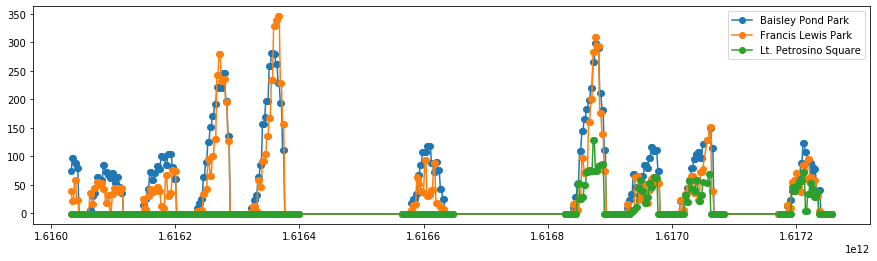

In [402]:
place_with_currpop = visualize_curr_pop_dynamics(nyc_df, nyc_parks, sample_size=3)

#### Where are these parks?

In [211]:
def visualize_curr_pop_location(place_id_to_display, info_df, city="New York City, NY", zoom_start=10):
    '''
    place_id_to_display: list with place ids
    info_df: table with basic information of id, name, and locations (index as id)
    
    '''
    geolocator = Nominatim(user_agent="loc_explorer")
    
    # center for visualization
    address = city
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    # create map using latitude and longitude values
    map_pa = folium.Map(location=[latitude, longitude], zoom_start=zoom_start)
    
    # add markers to map
    for item in place_id_to_display:
        if item in info_df.index: # sometimse only request_id is in the info table, skip...
            label = "{}".format(info_df.loc[item,'name'])
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [info_df.loc[item,'lat'], info_df.loc[item,'lng']], radius=5, popup=label, color='blue', 
                fill=True, fill_color='#3186cc', fill_opacity=0.7, 
                parse_html=False).add_to(map_pa)  

    map_pa

In [217]:
visualize_curr_pop_location(place_with_currpop, nyc_parks) #TODO, map not showing....

In [223]:
info_df = nyc_parks; place_id_to_display = place_with_currpop; zoom_start=10; city = "New York City, NY"
geolocator = Nominatim(user_agent="loc_explorer")
    
# center for visualization
address = city
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map using latitude and longitude values
map_pa = folium.Map(location=[latitude, longitude], zoom_start=zoom_start)

# add markers to map
for item in place_id_to_display:
    if item in info_df.index: # sometimse only request_id is in the info table, skip...
        label = "{}".format(info_df.loc[item,'name'])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [info_df.loc[item,'lat'], info_df.loc[item,'lng']], radius=5, popup=label, color='blue', 
            fill=True, fill_color='#3186cc', fill_opacity=0.7, 
            parse_html=False).add_to(map_pa)  

map_pa

## Stats on curr_popularity

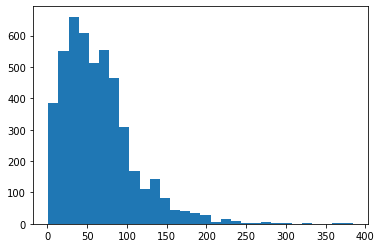

In [183]:
curr_pop_value = nyc_0317[nyc_0317['curr_popularity']>0]['curr_popularity'].tolist()
plt.hist(curr_pop_value, 30); 

## Construct current_popularity dataframe from multiple days
04112021

In [483]:
nyc_0331 = load_curr_popularity("data/nyc_outdoor_popularity_half_hour_0408_0409.db")
philly_0331 = load_curr_popularity("data/philly_outdoor_popularity_half_hour_0408_0409.db")

In [484]:
df_0331 = pd.concat([nyc_0331, philly_0331], axis=0)
df_0331.shape

(31227, 5)

In [516]:
# get datetime and align datetime to hour
#
# when the timestamp was recorded, "datetime.utcnow().timestamp() * 1000", it's at tz=utc
# fromtimestamp convert utc ts to local datetime format
#
df_0331['datetime'] = df_0331['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
# truncate to the hour, adding delta hour 1 to make records not ahead of weather data
df_0331['datetime_hour'] = df_0331['datetime'].apply(lambda x:x.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1))
df_0331.head()

,id,request_id,rating_n,timestamp,curr_popularity,datetime,datetime_hour
0,ChIJV9dre03Iw4kRkPuaCLgPMq8,ChIJV9dre03Iw4kRkPuaCLgPMq8,217,1617855761368,8,2021-04-08 00:22:41.368,2021-04-08 01:00:00
1,ChIJkWha9Paxw4kR1gOV_3ngZ3w,ChIJkWha9Paxw4kR1gOV_3ngZ3w,1012,1617855777532,7,2021-04-08 00:22:57.532,2021-04-08 01:00:00
2,ChIJFUDdWsOxw4kRlBkGxzYaOxE,ChIJFUDdWsOxw4kRlBkGxzYaOxE,844,1617855777610,25,2021-04-08 00:22:57.610,2021-04-08 01:00:00
3,ChIJ73wwPeCtw4kRltkpzF7hOQI,ChIJ73wwPeCtw4kRltkpzF7hOQI,164,1617855778516,52,2021-04-08 00:22:58.516,2021-04-08 01:00:00
4,ChIJfT3_kUKuw4kRI6OUXLC1140,ChIJfT3_kUKuw4kRI6OUXLC1140,287,1617855779219,9,2021-04-08 00:22:59.219,2021-04-08 01:00:00


In [489]:
df_0331[['datetime','datetime_hour']][:2]

,datetime,datetime_hour
0,2021-04-08 00:22:41.368,2021-04-08
1,2021-04-08 00:22:57.532,2021-04-08


In [524]:
df_0331_agg = df_0331.groupby(['datetime_hour', 'id']).agg({'curr_popularity': np.mean, 'rating_n': np.mean,
                                              'request_id': lambda x: x.iloc[0]}).reset_index()
print(df_0331_agg.shape)
df_0331_agg.head()

(15432, 5)


,datetime_hour,id,curr_popularity,rating_n,request_id
0,2021-04-08 01:00:00,ChIJ-5vusibGxokRv9RBx9foJhc,156.0,269.0,ChIJ-5vusibGxokRv9RBx9foJhc
1,2021-04-08 01:00:00,ChIJ-77FeARJwYkRG7c6z0zJiWs,32.0,716.0,ChIJ-77FeARJwYkRG7c6z0zJiWs
2,2021-04-08 01:00:00,ChIJ-btRQgDGxokRavFwlFZPh4A,17.0,268.0,ChIJ-btRQgDGxokRavFwlFZPh4A
3,2021-04-08 01:00:00,ChIJ-y1javpVwokRtSACB15lFBs,17.0,756.0,ChIJ-y1javpVwokRtSACB15lFBs
4,2021-04-08 01:00:00,ChIJ0SNFyYdLwokRHrw1PK2KDJE,6.0,595.0,ChIJ0SNFyYdLwokRHrw1PK2KDJE


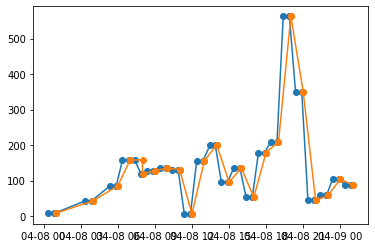

In [517]:
# example park
group_df = df_0331[df_0331['id']=='ChIJV9dre03Iw4kRkPuaCLgPMq8']
plt.plot(group_df['datetime'], group_df['curr_popularity'], '-o')
plt.plot(group_df['datetime_hour'], group_df['curr_popularity'], '-o')

# plt.plot(df_0331_agg[df_0331_agg['id']=='ChIJV9dre03Iw4kRkPuaCLgPMq8']['datetime_hour'], 
#          df_0331_agg[df_0331_agg['id']=='ChIJV9dre03Iw4kRkPuaCLgPMq8']['curr_popularity'], '-o')

In [520]:
df_curr_popularity = pd.read_parquet('curr_popularity_Date_2021-03-16_2021-04-10.parquet')
df_curr_popularity.head()

,datetime_hour,id,curr_popularity,rating_n,request_id
0,2021-04-07 01:00:00,ChIJ2R92Tl7Gx4kRO6G7NcWtNhk,34.0,1360.0,ChIJ2R92Tl7Gx4kRO6G7NcWtNhk
1,2021-04-07 01:00:00,ChIJ6RplJk13xokRN0DaW7aoDaA,46.0,441.0,ChIJ6RplJk13xokRN0DaW7aoDaA
2,2021-04-07 01:00:00,ChIJBf9gK23kx4kR7d1LnPPvyp8,1.0,593.0,ChIJBf9gK23kx4kR7d1LnPPvyp8
3,2021-04-07 01:00:00,ChIJKfnD4cK9x4kRHA-LRHfOQYs,23.0,1532.0,ChIJKfnD4cK9x4kRHA-LRHfOQYs
4,2021-04-07 01:00:00,ChIJOwA0J6YCuIkRaK-0pk4S95E,7.0,301.0,ChIJOwA0J6YCuIkRaK-0pk4S95E


In [521]:
df_curr_popularity.shape

(328192, 5)

In [525]:
15432 * 25

385800